# 결과 미리 요약
- Val acc: 96.43  
- classification report acc: 97.00  
- Precision/Recall: 0.96~0.97  
- conf_matrix: FN 180, FP 145  
- Val loss min: 0.1775  
- 그래프:  
  - 진동: 일부 튐 -> 최종 수렴으로 안정적  
    튀는 이유는 generator 또는 batch 구성 이슈일 가능성  
    -> validation_generator.samples가 batch_size * steps 보다 부족한 경우 발생함  
  - Epoch 8에서 튀었지만 빠르게 회복 -> Regularization, Dropout 작용  
  - 마지막 Epoch에서 val loss min값 도출  

- 다음 진행:
  - 이 모델을 baseline으로 이후  
  - dropout 위치 다양화  
  - Conv Layer 추가해보기  

In [2]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

In [5]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [6]:
# Dropout 증가 + L2 + Dense 노드 축소
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),  # Dense 노드 축소 + 정규화
    Dropout(0.4),  # Dropout 증가
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall')]
)

In [8]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    batch_size=32,
    class_weight={0: 2.0, 1: 1.0}
)

Epoch 1/20
1200/1200 [==============================] - 190s 154ms/step - loss: 0.7079 - accuracy: 0.8467 - recall: 0.7555 - val_loss: 0.9425 - val_accuracy: 0.6323 - val_recall: 0.2658
Epoch 2/20
1200/1200 [==============================] - 35s 29ms/step - loss: 0.4475 - accuracy: 0.9008 - recall: 0.8358 - val_loss: 0.8172 - val_accuracy: 0.6089 - val_recall: 0.2219
Epoch 3/20
1200/1200 [==============================] - 35s 29ms/step - loss: 0.3851 - accuracy: 0.9231 - recall: 0.8745 - val_loss: 1.2571 - val_accuracy: 0.5975 - val_recall: 0.9879
Epoch 4/20
1200/1200 [==============================] - 35s 30ms/step - loss: 0.4357 - accuracy: 0.9271 - recall: 0.8853 - val_loss: 0.9934 - val_accuracy: 0.7226 - val_recall: 0.4581
Epoch 5/20
1200/1200 [==============================] - 35s 30ms/step - loss: 0.3527 - accuracy: 0.9487 - recall: 0.9209 - val_loss: 1.3859 - val_accuracy: 0.5908 - val_recall: 0.8717
Epoch 6/20
1200/1200 [==============================] - 35s 29ms/step - loss: 

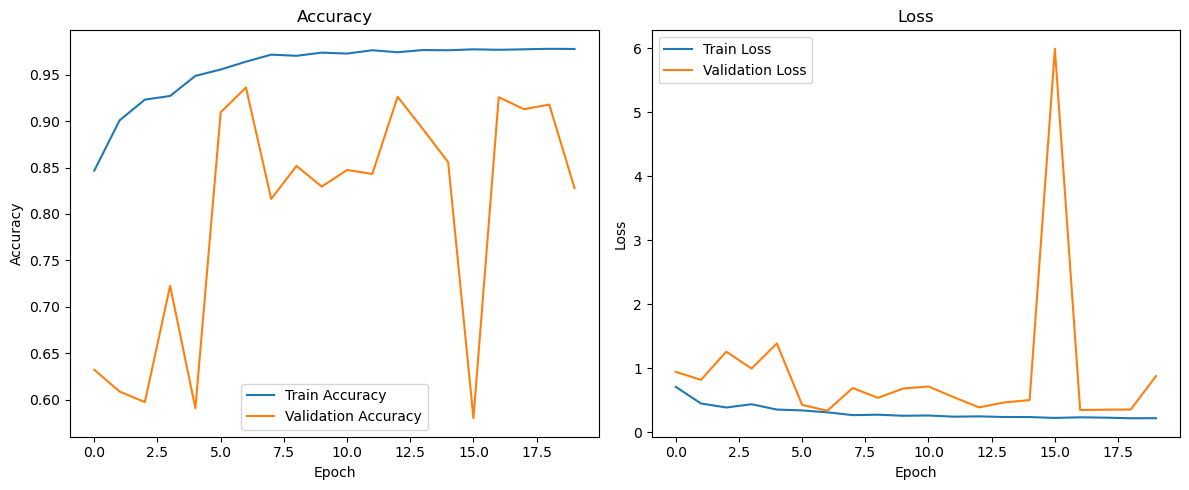

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/02_readjusted_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.75      1.00      0.86      4800
        open       1.00      0.66      0.80      4800

    accuracy                           0.83      9600
   macro avg       0.87      0.83      0.83      9600
weighted avg       0.87      0.83      0.83      9600



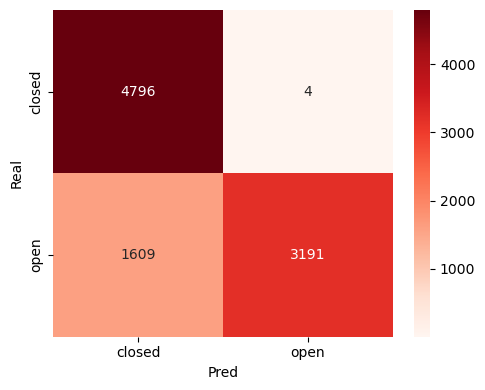

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/02_readjusted_classification_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/02_readjusted_confusion_matrix.png")
plt.show()

In [11]:
os.makedirs("../../src/models/08_Readjust_Model", exist_ok=True)
model.save("../../src/models/08_Readjust_Model/readjusted_model.keras")

# 잡동사니

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

def calculate_ear(eye_landmarks):
    # EAR 공식 적용
    A = np.linalg.norm(eye_landmarks[1] - eye_landmarks[5])
    B = np.linalg.norm(eye_landmarks[2] - eye_landmarks[4])
    C = np.linalg.norm(eye_landmarks[0] - eye_landmarks[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Mediapipe 얼굴 랜드마크 세팅
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# 이미지 불러오기
image = cv2.imread("path_to_image.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb_image)

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        landmarks = face_landmarks.landmark
        img_h, img_w, _ = image.shape

        # 왼쪽 눈의 인덱스 (MediaPipe 기준)
        left_eye_indices = [33, 160, 158, 133, 153, 144]  # EAR에 쓰이는 점들
        left_eye = np.array([[landmarks[i].x * img_w, landmarks[i].y * img_h] for i in left_eye_indices])

        ear_value = calculate_ear(left_eye)
        print(f"EAR: {ear_value:.4f}")

In [ ]:
# keras functional API 사용 예시
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model

image_input = Input(shape=(64, 64, 3))
ear_input = Input(shape=(1,))

# CNN branch
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = Flatten()(x)

# EAR + CNN 결합
combined = Concatenate()([x, ear_input])
z = Dense(64, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, ear_input], outputs=z)

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

def calculate_ear(eye_landmarks):
    A = np.linalg.norm(eye_landmarks[1] - eye_landmarks[5])
    B = np.linalg.norm(eye_landmarks[2] - eye_landmarks[4])
    C = np.linalg.norm(eye_landmarks[0] - eye_landmarks[3])
    return (A + B) / (2.0 * C)

# MediaPipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# 🔁 이미지 경로 바꾸기
image = cv2.imread("이미지_경로.jpg")  # 예: "sample.jpg"
if image is None:
    raise FileNotFoundError("이미지 경로를 확인하세요.")

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb_image)

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        landmarks = face_landmarks.landmark
        h, w, _ = image.shape

        # 왼쪽 눈 랜드마크 인덱스
        left_eye_indices = [33, 160, 158, 133, 153, 144]
        left_eye = np.array([[landmarks[i].x * w, landmarks[i].y * h] for i in left_eye_indices])

        ear = calculate_ear(left_eye)
        print(f"EAR 값: {ear:.4f}")
else:
    print("얼굴을 감지하지 못했습니다.")